In [1]:
import sqlite3
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize_scalar
from datetime import datetime

In [2]:
N = norm.cdf


In [3]:
def read_from_db():
    conn = sqlite3.connect('../../options_database.db')
    df = pd.read_sql_query("SELECT * FROM options_table", conn)
    conn.close()
    return df

In [4]:
df = read_from_db()

In [5]:
len(df[(df.current_time == '2023-01-29 11:24:46.988931')])

610

In [6]:
def delta_BS_put(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    return N(d1) - 1

def delta_BS_call(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    return N(d1)

def BS_CALL(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
#     print(d1, d2)
    return S * N(d1) - K * np.exp(-r*T)* N(d2)

def BS_PUT(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return K * np.exp(-r*T)* N(-d2) - S * N(-d1)

In [7]:
BS_PUT(1000, 1000, 1, 0, 0.0000001)

3.989422810946053e-05

In [8]:
def get_timedelta_in_years(timedelta):
    d = timedelta.days / (365.25)
    s = timedelta.seconds / (365.25*24*60*60)
    return d + s

In [146]:
def preprocessing(option_name, option_type):
    selected_option = (df[(df.full_name == option_name)][df.current_time > '2023-01-04'][df.type == option_type])
    selected_option['timedelta'] = selected_option.apply(lambda x: get_timedelta_in_years(datetime.fromisoformat(x['expiry']) - datetime.fromisoformat(x['current_time'])), axis=1)
    
    selected_option['mid_price'] = selected_option['mid_price'].fillna(0)
    selected_option['ask_price'] = selected_option['ask_price'].fillna(0)
    selected_option['bid_price'] = selected_option['bid_price'].fillna(0)
    selected_option['strike'] = selected_option['strike'].astype(float)
    # selected_option['mid_IV'] = selected_option['mid_IV'].fillna(0.001)
    
    
    filtered = selected_option.loc[(selected_option.bid_IV > 0) & (selected_option.bid_IV < 10) & 
                            (selected_option.ask_IV > 0) & (selected_option.ask_IV < 10) &
                             (selected_option.timedelta > 0)]
    
    
    # (selected_option.bid_IV < 10) & 
    #                                (selected_option.ask_IV < 10) &
    #                                (selected_option.mid_IV < 10) &
    
    # filtered = selected_option.loc[
    #                                (selected_option.timedelta > 0)]
    
    
    if option_type == 'put':
        filtered['BS_delta'] = delta_BS_put(filtered.underlying_price, filtered.strike, filtered.timedelta, 0, filtered.mid_IV)
    elif option_type == 'call':
        filtered['BS_delta'] = delta_BS_call(filtered.underlying_price, filtered.strike, filtered.timedelta, 0, filtered.mid_IV)
    
    filtered.index = np.arange(1, len(filtered)+1)
    
    return filtered



In [147]:
def backtest(df):
    
    asset = 0  
    initial_usdc = 0
    usdc = initial_usdc
    prev_asset = asset

    for i in range(len(df)):
        prev_asset = asset
        asset = df['BS_delta'].iloc[i]
        usdc = usdc - (asset - prev_asset) * df['underlying_price'].iloc[i]

    return asset*df['underlying_price'].iloc[-1] + usdc - initial_usdc

In [148]:
# datetime.strptime(selected_put.iloc[5]['expiry'], "%Y %m %d %I:%M%p")
# get_timedelta_in_years(datetime.fromisoformat(selected_put.iloc[5]['expiry']) - datetime.fromisoformat(selected_put.iloc[5]['current_time']))


In [290]:
def calculate_option_PnL(init_underlying_price, final_underlying_price, 
                         strike, init_option_price_in_underlying, final_option_price_in_underlying):
    
    PnL = final_option_price_in_underlying * final_underlying_price - init_option_price_in_underlying * init_underlying_price
    return PnL


In [291]:
def test(option_name):
    filtered = preprocessing(option_name = option_name, option_type = 'put')
    # print(filtered['current_time'].iloc[0])
    return filtered
    
    replicated_pnl = backtest(filtered[filtered.index % 10 == 0])
    
    option_price = filtered['mid_price'].iloc[0] * filtered['underlying_price'].iloc[0]

    price_on_expiry = filtered['underlying_price'].iloc[-1]
    
    pnl = calculate_option_PnL(filtered['underlying_price'].iloc[-1], filtered['strike'].iloc[-1], filtered['mid_price'].iloc[0])

    
    return (replicated_pnl, pnl, price_on_expiry)

In [292]:
# (test('ETH-24FEB23-1400'))
# t[t['BS_delta'] < -1]

In [293]:
# def get_max_option_pnl(option_names):
#     max_pnl = -np.inf
#     for option_name in option_names:
#         filtered = preprocessing(option_name = option_name, option_type = 'put')
#         option_price = filtered['mid_price'].iloc[0] * filtered['underlying_price'].iloc[0]
#         price_on_expiry = filtered['underlying_price'].iloc[-1]
#         pnl = calculate_option_PnL(filtered['underlying_price'].iloc[-1], filtered['strike'].iloc[0], 
#                                filtered['mid_price'].iloc[0], filtered['mid_price'].iloc[-1])
        
#         if abs(pnl) > max_pnl:
#             max_pnl = abs(pnl)
    
#     return max_pnl
    

In [294]:
def performance(option_name):
    filtered = preprocessing(option_name = option_name, option_type = 'put')
    replicated_pnl = backtest(filtered[filtered.index % 10 == 0])
    
    init_option_price = filtered['mid_price'].iloc[0] * filtered['underlying_price'].iloc[0]

    final_option_price = filtered['mid_price'].iloc[-1] * filtered['underlying_price'].iloc[-1]
    
    initial_price = filtered['underlying_price'].iloc[0]

    pnl = calculate_option_PnL(filtered['underlying_price'].iloc[0], filtered['underlying_price'].iloc[-1], filtered['strike'].iloc[0], 
                               filtered['mid_price'].iloc[0], filtered['mid_price'].iloc[-1])
    print('------')
    print('option_name:', option_name)
    print('start time:', filtered['current_time'].iloc[0])
    print('init_option_price: {}, final_option_price: {}'.format(init_option_price, final_option_price))
    print("rep_pnl: {}, initial_price: {}, pnl: {}".format(replicated_pnl, initial_price, pnl))
    print('------')

    shift = 2 * max(abs(replicated_pnl), abs(pnl))
    
    # if pnl > 0:
    #     if replicated_pnl > 0:

    #     else:
    #         return 
    # else:
    #     if replicated_pnl > 0:
    #         return (replicated_pnl + pnl) / pnl
    #     else:
    #         return pnl / replicated_pnl
    
    return [option_name, (replicated_pnl + shift) / (pnl + shift)]


In [295]:
# df.full_name.drop_duplicates().to_numpy()

In [296]:
options_names = ['ETH-27JAN23-1200', 'ETH-27JAN23-1300', 'ETH-27JAN23-1400', 'ETH-27JAN23-1500', 'ETH-27JAN23-1600', 'ETH-27JAN23-1700']

options_names = options_names + ['ETH-24FEB23-900', 'ETH-24FEB23-1000', 'ETH-24FEB23-1100', 'ETH-24FEB23-1200', 'ETH-24FEB23-1300', 'ETH-24FEB23-1400',
                'ETH-24FEB23-1500', 'ETH-24FEB23-1600', 'ETH-24FEB23-1700']

In [297]:
options_names

['ETH-27JAN23-1200',
 'ETH-27JAN23-1300',
 'ETH-27JAN23-1400',
 'ETH-27JAN23-1500',
 'ETH-27JAN23-1600',
 'ETH-27JAN23-1700',
 'ETH-24FEB23-900',
 'ETH-24FEB23-1000',
 'ETH-24FEB23-1100',
 'ETH-24FEB23-1200',
 'ETH-24FEB23-1300',
 'ETH-24FEB23-1400',
 'ETH-24FEB23-1500',
 'ETH-24FEB23-1600',
 'ETH-24FEB23-1700']

In [298]:
# shift = get_max_option_pnl(options_names)

In [299]:
# shift

In [300]:
res = []

for option_name in options_names:
    # print(option_name)
    res.append(performance(option_name))

/var/folders/8t/1dvfc69d0l3137hz8kyzv__80000gn/T/ipykernel_5865/1588272677.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/8t/1dvfc69d0l3137hz8kyzv__80000gn/T/ipykernel_5865/1588272677.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/8t/1dvfc69d0l3137hz8kyzv__80000gn/T/ipykernel_5865/1588272677.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/8t/1dvfc69d0l3137hz8kyzv__80000gn/T/ipykernel_5865/1588272677.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

------
option_name: ETH-27JAN23-1200
start time: 2023-01-04 00:08:26.027061
init_option_price: 59.325770000000006, final_option_price: 1.1572200000000001
rep_pnl: -66.46311779650334, initial_price: 1210.73, pnl: -58.16855
------
------
option_name: ETH-27JAN23-1300
start time: 2023-01-04 00:08:26.027061
init_option_price: 118.34885750000001, final_option_price: 1.1661
rep_pnl: -131.39436491731982, initial_price: 1210.73, pnl: -117.18275750000001
------


/var/folders/8t/1dvfc69d0l3137hz8kyzv__80000gn/T/ipykernel_5865/1588272677.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/8t/1dvfc69d0l3137hz8kyzv__80000gn/T/ipykernel_5865/1588272677.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/8t/1dvfc69d0l3137hz8kyzv__80000gn/T/ipykernel_5865/1588272677.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/8t/1dvfc69d0l3137hz8kyzv__80000gn/T/ipykernel_5865/1588272677.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

------
option_name: ETH-27JAN23-1400
start time: 2023-01-04 00:08:26.027061
init_option_price: 201.58488000000003, final_option_price: 1.219035
rep_pnl: -211.5770224376294, initial_price: 1210.72, pnl: -200.36584500000004
------
------
option_name: ETH-27JAN23-1500
start time: 2023-01-12 03:56:21.573827
init_option_price: 115.8455, final_option_price: 1.1990475
rep_pnl: -122.55655000633664, initial_price: 1412.75, pnl: -114.6464525
------


/var/folders/8t/1dvfc69d0l3137hz8kyzv__80000gn/T/ipykernel_5865/1588272677.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/8t/1dvfc69d0l3137hz8kyzv__80000gn/T/ipykernel_5865/1588272677.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/8t/1dvfc69d0l3137hz8kyzv__80000gn/T/ipykernel_5865/1588272677.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/8t/1dvfc69d0l3137hz8kyzv__80000gn/T/ipykernel_5865/1588272677.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

------
option_name: ETH-27JAN23-1600
start time: 2023-01-14 03:55:18.045434
init_option_price: 119.169725, final_option_price: 9.65232
rep_pnl: -82.06062183915697, initial_price: 1552.7, pnl: -109.517405
------
------
option_name: ETH-27JAN23-1700
start time: 2023-01-16 05:55:43.315596
init_option_price: 167.698095, final_option_price: 96.4284
rep_pnl: -89.63718020028477, initial_price: 1574.63, pnl: -71.269695
------


/var/folders/8t/1dvfc69d0l3137hz8kyzv__80000gn/T/ipykernel_5865/1588272677.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/8t/1dvfc69d0l3137hz8kyzv__80000gn/T/ipykernel_5865/1588272677.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



------
option_name: ETH-24FEB23-900
start time: 2023-01-04 00:08:26.027061
init_option_price: 23.2899975, final_option_price: 1.5866600000000002
rep_pnl: -24.370388131479626, initial_price: 1209.87, pnl: -21.703337499999996
------
------
option_name: ETH-24FEB23-1000
start time: 2023-01-04 00:08:26.027061
init_option_price: 38.413372499999994, final_option_price: 3.1733200000000004
rep_pnl: -40.26822782202632, initial_price: 1209.87, pnl: -35.24005249999999
------


/var/folders/8t/1dvfc69d0l3137hz8kyzv__80000gn/T/ipykernel_5865/1588272677.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/8t/1dvfc69d0l3137hz8kyzv__80000gn/T/ipykernel_5865/1588272677.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



------
option_name: ETH-24FEB23-1100
start time: 2023-01-04 00:08:26.027061
init_option_price: 62.913239999999995, final_option_price: 5.949975
rep_pnl: -64.4397177319082, initial_price: 1209.87, pnl: -56.96326499999999
------
------
option_name: ETH-24FEB23-1200
start time: 2023-01-04 00:08:26.027061
init_option_price: 102.234015, final_option_price: 9.916625000000002
rep_pnl: -100.85769124153165, initial_price: 1209.87, pnl: -92.31739
------


/var/folders/8t/1dvfc69d0l3137hz8kyzv__80000gn/T/ipykernel_5865/1588272677.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/8t/1dvfc69d0l3137hz8kyzv__80000gn/T/ipykernel_5865/1588272677.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



------
option_name: ETH-24FEB23-1300
start time: 2023-01-04 00:08:26.027061
init_option_price: 157.2831, final_option_price: 18.24659
rep_pnl: -149.98505801944847, initial_price: 1209.87, pnl: -139.03651
------
------
option_name: ETH-24FEB23-1400
start time: 2023-01-04 00:08:26.027061
init_option_price: 229.57283249999998, final_option_price: 33.319860000000006
rep_pnl: -204.51362335283176, initial_price: 1209.87, pnl: -196.25297249999997
------


/var/folders/8t/1dvfc69d0l3137hz8kyzv__80000gn/T/ipykernel_5865/1588272677.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/8t/1dvfc69d0l3137hz8kyzv__80000gn/T/ipykernel_5865/1588272677.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/8t/1dvfc69d0l3137hz8kyzv__80000gn/T/ipykernel_5865/1588272677.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/8t/1dvfc69d0l3137hz8kyzv__80000gn/T/ipykernel_5865/1588272677.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

------
option_name: ETH-24FEB23-1500
start time: 2023-01-05 12:21:17.338039
init_option_price: 277.9169575, final_option_price: 60.29308
rep_pnl: -177.244372920344, initial_price: 1250.47, pnl: -217.62387750000002
------
------
option_name: ETH-24FEB23-1600
start time: 2023-01-12 11:30:28.103970
init_option_price: 245.60008, final_option_price: 105.90955500000001
rep_pnl: -139.14661365364634, initial_price: 1397.44, pnl: -139.69052499999998
------
------
option_name: ETH-24FEB23-1700
start time: 2023-01-12 22:53:54.692214
init_option_price: 304.2838125, final_option_price: 169.375955
rep_pnl: -23.53108911861318, initial_price: 1423.55, pnl: -134.9078575
------


/var/folders/8t/1dvfc69d0l3137hz8kyzv__80000gn/T/ipykernel_5865/1588272677.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/8t/1dvfc69d0l3137hz8kyzv__80000gn/T/ipykernel_5865/1588272677.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [301]:
res

[['ETH-27JAN23-1200', 0.8890472901788273],
 ['ETH-27JAN23-1300', 0.9023968097636963],
 ['ETH-27JAN23-1400', 0.9496778669431029],
 ['ETH-27JAN23-1500', 0.9393707307028928],
 ['ETH-27JAN23-1600', 1.2507070283562967],
 ['ETH-27JAN23-1700', 0.8299380389526403],
 ['ETH-24FEB23-900', 0.9013571272463339],
 ['ETH-24FEB23-1000', 0.888993938303763],
 ['ETH-24FEB23-1100', 0.8960393374161951],
 ['ETH-24FEB23-1200', 0.9219336566632717],
 ['ETH-24FEB23-1300', 0.9319685410093759],
 ['ETH-24FEB23-1400', 0.9611764585560414],
 ['ETH-24FEB23-1500', 1.1855472158823932],
 ['ETH-24FEB23-1600', 1.00389368818217],
 ['ETH-24FEB23-1700', 1.825576585718047]]

In [319]:
print(np.mean(list(map(lambda x: x[1], res[:-1]))))
print(np.std(list(map(lambda x: x[1], res[:-1]))))

0.9608605520112142
0.11272820013120459


In [302]:
# filtered

#### Todo: run multiple replications (for diff strike, expiries) and draw a performance distribution

In [303]:
import plotly.graph_objs as go
import plotly.express as px

In [304]:
# fig = px.bar(res[0], x=np.array([res[0][0]]), y=np.array([res[1][1]]), title="Long-Form Input")

# fig.show()

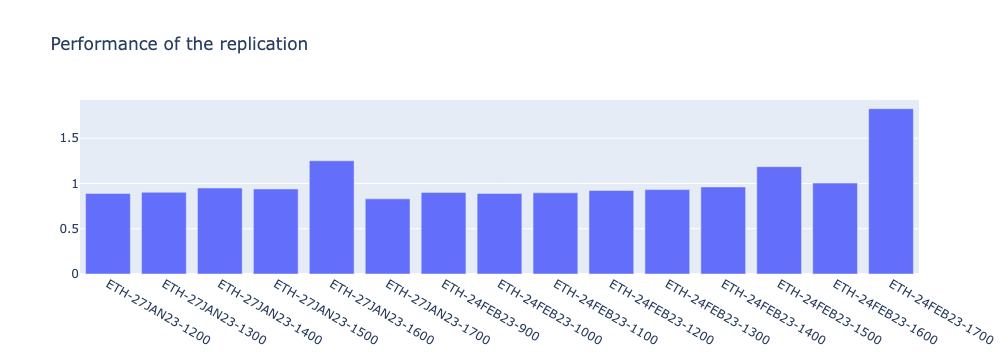

In [313]:
dices2 = pd.DataFrame(np.random.randint(low=1, high=7, size=(100, 2)), columns=('Кость 1', 'Кость 2'))
dices2['Сумма'] = dices2['Кость 1'] + dices2['Кость 2']
dices3 = pd.DataFrame(np.random.randint(low=1, high=7, size=(1000, 2)), columns=('Кость 1', 'Кость 2'))
dices3['Сумма'] = dices3['Кость 1'] + dices3['Кость 2']

fig = go.Figure(layout = {"title": {"text": "Performance of the replication"}})
# fig.add_trace(go.Histogram(x=dices['Сумма']))
for i in range(len(res)):
    # fig.add_trace(go.Histogram(x=r))
    # fig.add_trace(go.Histogram(x=r))
    fig2 = px.bar(res[i], x=np.array([res[i][0]]), y=np.array([res[i][1]]))
    
    # fig2 = px.bar(df, x="x", y="y")
    fig.add_trace(fig2.data[0])

# fig.add_trace(go.Histogram(x=dices3['Сумма']))
fig.show()